In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import re
from jupyterthemes import jtplot
from datetime import timedelta, datetime
import calendar
import plotly.express as px
import sklearn
jtplot.style()

# Read in ce, filter down to testing

In [ ]:
ce = pd.read_csv('../data/ce.csv', converters = {'DATETIME':pd.to_datetime})

In [5]:
ce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9547413 entries, 0 to 9547412
Data columns (total 12 columns):
 #   Column             Dtype         
---  ------             -----         
 0   DATETIME           datetime64[ns]
 1   USER               int64         
 2   RETRY              int64         
 3   TIMELAPSE          float64       
 4   RETURNCODE         int64         
 5   COMMAND            object        
 6   JOBID              float64       
 7   COMMANDTYPE        object        
 8   TESTING            bool          
 9   UNRESPONSIVE       bool          
 10  SERVER             object        
 11  UNRESPONSIVEGROUP  float64       
dtypes: bool(2), datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 746.6+ MB


In [12]:
testing = ce[ce['TESTING']]

# Read in slurm_jobs

In [7]:
slurm_jobs = pd.read_csv('../data/slurm_jobs.csv')

In [8]:
datetime_cols = ['BEGIN', 'END']
for col in datetime_cols:
    slurm_jobs[col] = pd.to_datetime(slurm_jobs[col])

timedelta_cols = ['REQTIME', 'USEDTIME']
for col in timedelta_cols:
    slurm_jobs[col] = pd.to_timedelta(slurm_jobs[col])

In [10]:
slurm_jobs = slurm_jobs.drop(columns = 'ROLL1HR')

In [18]:
slurm_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395234 entries, 0 to 7395233
Data columns (total 16 columns):
 #   Column     Dtype          
---  ------     -----          
 0   JOBID      object         
 1   STATE      object         
 2   BEGIN      datetime64[ns] 
 3   END        datetime64[ns] 
 4   REQMEM     object         
 5   USEDMEM    object         
 6   REQTIME    timedelta64[ns]
 7   USEDTIME   timedelta64[ns]
 8   NODES      int64          
 9   CPUS       int64          
 10  PARTITION  object         
 11  EXITCODE   int64          
 12  TIMEOUT    bool           
 13  SIGNAL     int64          
 14  IN_ARRAY   bool           
 15  ARRAYID    float64        
dtypes: bool(2), datetime64[ns](2), float64(1), int64(4), object(5), timedelta64[ns](2)
memory usage: 804.0+ MB


## Problem 4

Finally, combine the time series information from the two datasets together to see 

(4A) how well correlated heavy job-completion load is with the unresponsiveness, and 

(4B) to see if there is some threshold of job completions per hour that generally results in unresponsiveness.

## (4A) How well correlated is heavy job-completion load with unresponsiveness?

-- Mix in logs (testing) with jobs (slurm_jobs)

   * concatenate slurm_jobs and testing; call it slurm_testing
    
-- Create rolling window to check for unresponsivenss

   * sort and reset index of slurm_testing
   * create rolling window for jobs completed in our prior to each entry; call the column ROLL1HR
   * filter slurm_testing down to TESTING == True; call it slurm_tests
   * create rolling window of jobs completed in our prior to each test
   * ensure UNRESPONSIVE is boolean
   * filter out late-May downtime; call it slurm_tests_filt
    
-- Make logistic regression model

   * Make the base model with sm.GLM
   * Make the model with ROLL1HR as exog
   * Plot the model
   * Make model with Logit to confirm results and to construct confusion matrix

### Mix in logs (testing) with jobs (slurm_jobs)

In [19]:
testing = testing.rename(columns = {'DATETIME' : 'END'}).drop(columns = 'JOBID')

### Create rolling window of jobs completed in our prior to each test

In [20]:
slurm_testing = pd.concat([slurm_jobs, testing])
slurm_testing = slurm_testing.sort_values('END').reset_index(drop = True)

In [24]:
slurm_testing['ROLL1HR'] = (slurm_testing
                           .rolling('1h', on = 'END')
                            ['JOBID']
                            .count()
                        )

In [31]:
slurm_tests = slurm_testing[slurm_testing['TESTING'] == True]

In [38]:
slurm_tests['UNRESPONSIVE'] = slurm_tests['UNRESPONSIVE'].astype('boolean')

<ipython-input-38-0a253f79b66b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slurm_tests['UNRESPONSIVE'] = slurm_tests['UNRESPONSIVE'].astype('boolean')


In [57]:
slurm_tests_filt = slurm_tests[(slurm_tests['END'] < '2021-05-18') | (slurm_tests['END'] >= '2021-06-01')]

### Make logistic regression model: ROLL1HR model shows AIC improvement over base model. Significant result: With each increase of 100 jobs per hour, the odds of unresponsiveness increases by 1.0144 times. e.g. The model predicts that the odds of unresponsiveness are 1.0144 times higher at 800 jobs per hour than they are at 700 jobs per hour.

In [58]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_tests_filt['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_tests_filt[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_base.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:                58782
Model:                            GLM   Df Residuals:                    58781
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12514.
Date:                Sat, 06 Nov 2021   Deviance:                       25028.
Time:                        17:05:28   Pearson chi2:                 5.88e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8445      0.018   -157.181      0.0

In [59]:
logreg_unresponsive_roll = (sm.GLM(endog = slurm_tests_filt['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_tests_filt['ROLL1HR']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:                58782
Model:                            GLM   Df Residuals:                    58780
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12505.
Date:                Sat, 06 Nov 2021   Deviance:                       25011.
Time:                        17:05:40   Pearson chi2:                 5.88e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7876      0.023   -121.772      0.0

### Plot the model

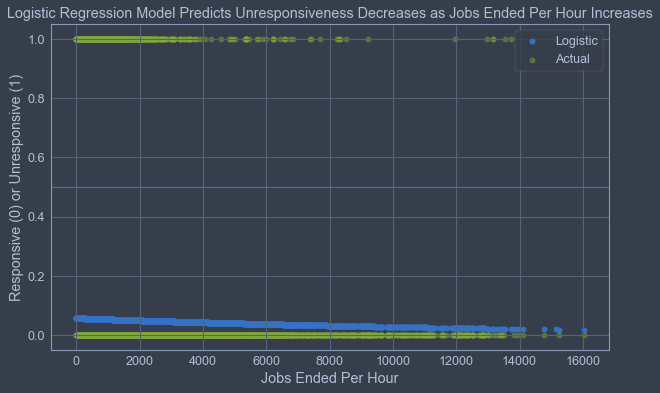

In [73]:
fig, ax = plt.subplots(figsize = (10,6))

x = slurm_tests['ROLL1HR']
y_logistic = 1/(1+np.exp(-(-2.7876 + (-7.347e-05*x))))
plt.scatter(x, y_logistic, label = 'Logistic')

x = slurm_tests['ROLL1HR']
y = slurm_tests['UNRESPONSIVE'].astype('int')
plt.scatter(x, y, label = 'Actual', alpha = 0.5)
ax.axhline(0.5)
plt.legend()
plt.title("Logistic Regression Model Predicts Unresponsiveness Decreases as Jobs Ended Per Hour Increases")
plt.ylabel("Responsive (0) or Unresponsive (1)")
plt.xlabel("Jobs Ended Per Hour");

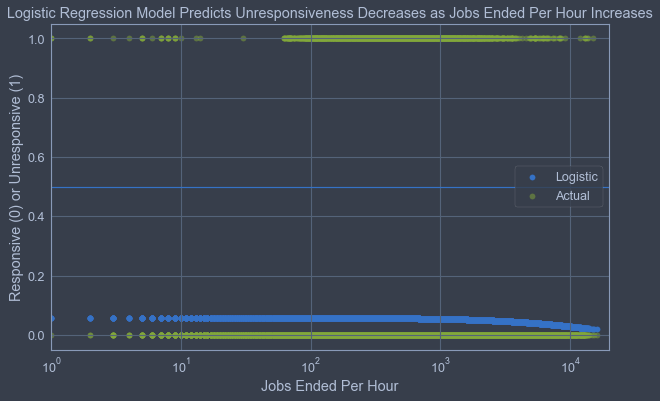

In [81]:
fig, ax = plt.subplots(figsize = (10,6))

x = slurm_tests['ROLL1HR']
y_logistic = 1/(1+np.exp(-(-2.7876 + (-7.347e-05*x))))
plt.scatter(x, y_logistic, label = 'Logistic')

x = slurm_tests['ROLL1HR']
y = slurm_tests['UNRESPONSIVE'].astype('int')
plt.scatter(x, y, label = 'Actual', alpha = 0.5)
ax.set(xscale = 'log', xlim = (1, 20000))
ax.axhline(0.5)
plt.legend()
plt.title("Logistic Regression Model Predicts Unresponsiveness Decreases as Jobs Ended Per Hour Increases")
plt.ylabel("Responsive (0) or Unresponsive (1)")
plt.xlabel("Jobs Ended Per Hour");

# APPENDIX: Valley of Dry Bones

In [19]:
# regex = re.compile(r'((?P<hours>\d+?)h)?((?P<minutes>\d+?)m)?((?P<seconds>\d+?)s)?')

# def parse_time(time_str):
#     parts = regex.match(time_str)
#     if not parts:
#         return
#     parts = parts.groupdict()
#     time_params = {}
#     for name, param in parts.items():
#         if param:
#             time_params[name] = int(param)
#     return timedelta(**time_params)

In [20]:
# def check_unresponsive(x, window = '1h'):
#     cef = ce.loc[(ce['DATETIME'] >= x - parse_time(window))
#                  &
#                  (ce['DATETIME'] <= x)]
#     unresp = cef['UNRESPONSIVE'].any()
#     return unresp

In [21]:
#slurm_jobs['END'].apply(check_unresponsive)

<AxesSubplot:xlabel='END'>

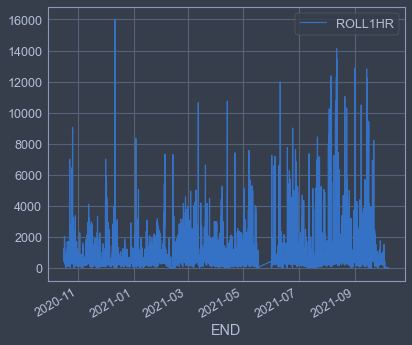

In [74]:
slurm_tests_filt.plot(x = 'END', y = 'ROLL1HR')

KeyboardInterrupt: 

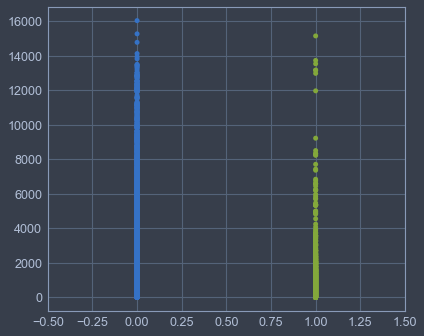

In [92]:
fline = slurm_tests.loc[slurm_tests['UNRESPONSIVE'] == False, 'ROLL1HR'].mean()
tline = slurm_tests.loc[slurm_tests['UNRESPONSIVE'] == True, 'ROLL1HR'].mean()

ax = sns.swplot(data = slurm_tests, x = 'UNRESPONSIVE', y = 'ROLL1HR')
ax.axhline(fline)
ax.axhline(tline, color = '#83A83B')